# Interaction between two particles

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from scipy.linalg import eigh


sys.path.append('.')
from model import AssociativeMemory, get_embeddings

torch.manual_seed(42)

We consider the settings where $y = x$, $d=2$, $f_i$ is the canonical basis of $\R^2$, $u_y = f_y$, $e_1 = f_1$, $e_2 = \alpha f_1 + \sqrt{1-\alpha^2} f_2$.

In [96]:
# hyparameters
n = 2
d = 2
alpha = -.5      # angle between the two tokens
p = .75         # probability of the first tokens

def f(x, epsilon=0):
    return x

# data
all_x = torch.arange(n)
all_y = f(all_x)
proba = torch.tensor([p, 1-p])

E = torch.eye(n)
U = torch.eye(n)
E[1,0] = alpha
E[1,1] = np.sqrt(1-alpha**2)

model = AssociativeMemory(E, U)

For any parameter $W$, the sufficient statistics are given by $\gamma_i = f_i^\top W (u_2 - u_1)$.
Reciprocally, for some values $(\gamma_i)$, one can set $W = \sum \gamma_i f_i \otimes (u_2 - u_1) / 2$.

In [99]:
lim = 10
num = 50
gamma_0, gamma_1 = np.meshgrid(np.linspace(-lim, lim, num=num), np.linspace(-lim, lim, num=num))

Ws = np.zeros((num * num, d, d))
Ws[:, 0, 0] = gamma_0.flatten()
Ws[:, 1, 0] = gamma_1.flatten()
Ws[:, 0, 1] = -Ws[:, 0, 0]
Ws[:, 1, 1] = -Ws[:, 1, 0]
Ws /= 2
Ws = torch.tensor(Ws, dtype=torch.float32)

score = E @ (Ws @ U.T)

assert (score[:, 0, 0] - score[:, 0, 1] == torch.tensor(gamma_0.flatten(), dtype=torch.float32)).all()
if alpha == 0:
    assert (score[:, 1, 0] - score[:, 1, 1] == torch.tensor(gamma_1.flatten(), dtype=torch.float32)).all()

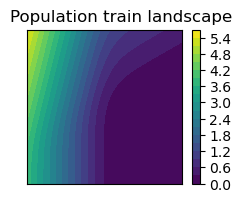

In [100]:
log_likelihood = F.log_softmax(score, dim=2)
log_likelihood = log_likelihood[:, all_x, all_y]
train_loss = (log_likelihood * (-proba)).mean(dim=1)
Z = train_loss.numpy()
fig, ax = plt.subplots(figsize=(2.5, 2))
c = ax.contourf(gamma_0, gamma_1, Z.reshape(num, num), levels=20)
fig.colorbar(c)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle('Population train landscape')
fig.savefig('population_train_landscape.pdf', bbox_inches='tight', pad_inches=0)

In [101]:
H = np.zeros((num**2, n))
for i in range(num**2):
    model.W.data = Ws[i]
    for j in range(n):
        H[i, j] = eigh(model.hessian(all_x[j:j+1]).numpy(), eigvals_only=True).max()

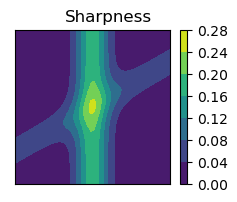

In [102]:
Z = (H * proba.numpy()).mean(axis=1)
fig, ax = plt.subplots(figsize=(2.5, 2))
c = ax.contourf(gamma_0, gamma_1, Z.reshape(num, num))
fig.colorbar(c)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle('Sharpness')
fig.savefig('sharpness.pdf', bbox_inches='tight', pad_inches=0)